# Lab9 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt

## Working with Shape File

### Loading Census Tract Shape File¶

In [3]:
#Boro City 2010 is the census tract file
from geopandas import GeoDataFrame
shape_path="Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [4]:
#Just checking that everything appears to make sense. 
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

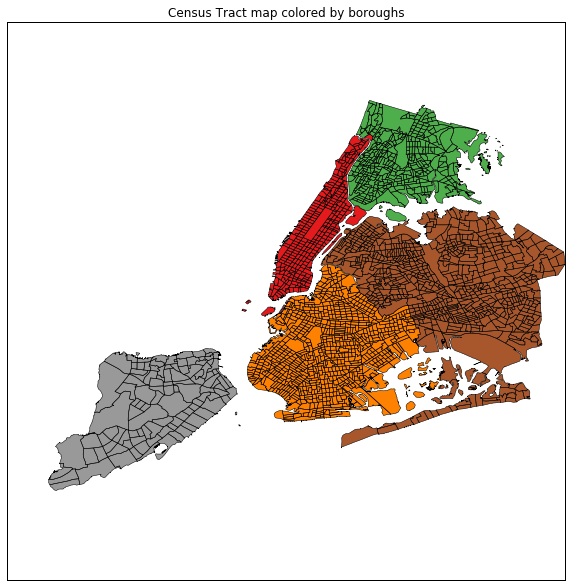

In [5]:
#Heat map to correspond to the boro column. Colors are random, corresponding to Boro value. 
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

<b>Figure 1:</b> Census tracts by borough in New York City

### Map NYC Population density

#### Load Census Data for 2010

In [6]:
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [7]:
#Don't need to specify indicies because 'join' auto searches for it and matches the two datasets based on the 
#indicies in common.
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

/opt/rh/anaconda/root/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


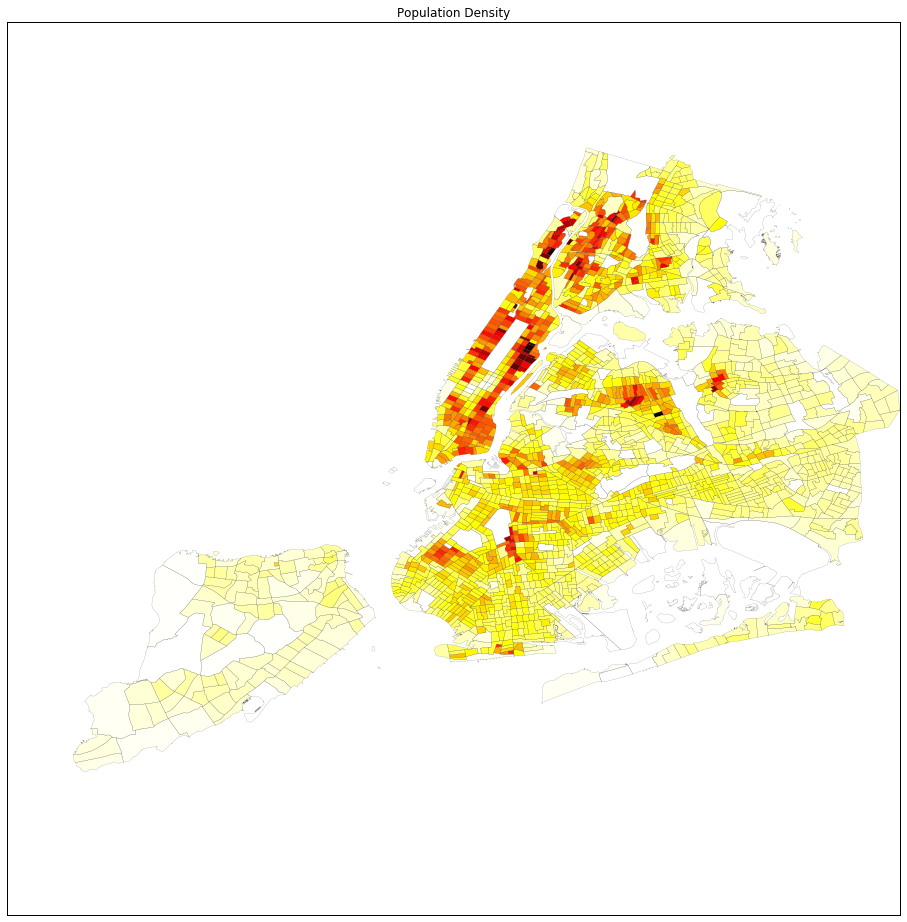

In [8]:
f, ax = plt.subplots(figsize=(16,16))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density")

<b>Figure 2:</b> Visualization of New York City's population density. Darker colors and reds indicate higher concentrations of population density.

## Explore CitiBike data

### Load CitiBike data

In [9]:
df_bike_monthly=DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


### Time Series Analysis

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

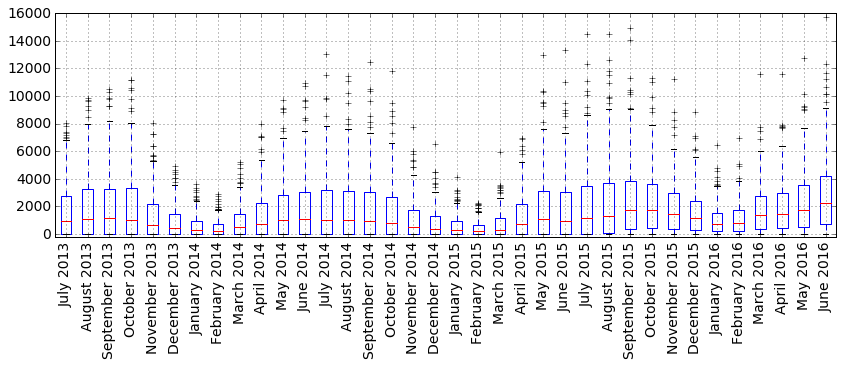

In [10]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_=df_bike_monthly.copy()
df_bike_monthly_.index=df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

<b>Figure 3: </b>Time series analysis of Citibike rides showing clear periodicity and seasonality of ridership. 

#### Seasonal Decomposition

/opt/rh/anaconda/root/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


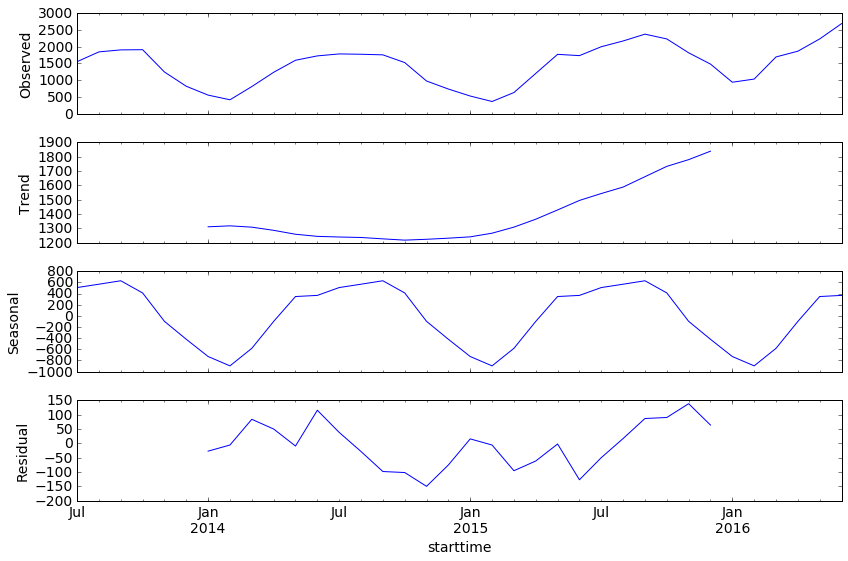

In [11]:
import statsmodels.api as sm

#Create a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

<b>Figure 4: </b> Seasonal decomposition of Citibike rides from July 2013 to July 2016.

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [12]:
station_id=DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Coordinates (Lat & Lon)

In [13]:
import shapely
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [14]:
a=[]
# check for each citibike stations to see what CT they are belong to
# stations will belong to one tract or another... there is no overlap. Sites on a line
# belong to one tract or the other. That's what the intersects do. 
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [15]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add the monthly average rides to the CT shapefile 

In [16]:
df_summer = df_bike_monthly[(df_bike_monthly.index.month <= 9) & (df_bike_monthly.index.month >= 6)]
df_winter = df_bike_monthly[(df_bike_monthly.index.month <= 3) | (df_bike_monthly.index.month == 12)]

In [17]:
#Using mean instead of sum to smooth out counts across time and balance the scales for the handful of
#bike stations that were created after others in the data set.
station_id['WinterAverage']=df_winter.mean()
station_id['SummerAverage']=df_summer.mean()

In [18]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,WinterAverage,SummerAverage
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,1096.916667,2558.000000
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,1342.750000,3830.500000
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,4411.666667,9903.083333
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,1628.416667,3732.833333
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,2609.916667,6895.750000


In [19]:
temp=station_id[['WinterAverage']]
temp['station_id']=station_id.index
temp.index=station_id['BoroCT2010']#set the index of this new temp dataframe, since shape file index is boroct
ct_shape_WinterAverage=ct_shape.join(temp)#join the temp dataframe to the shape file
ct_shape_WinterAverage.fillna(0,inplace=True)

temp2=station_id[['SummerAverage']]
temp2['station_id']=station_id.index
temp2.index=station_id['BoroCT2010']#set the index of this new temp dataframe, since shape file index is boroct
ct_shape_SummerAverage=ct_shape.join(temp2)#join the temp dataframe to the shape file
ct_shape_SummerAverage.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


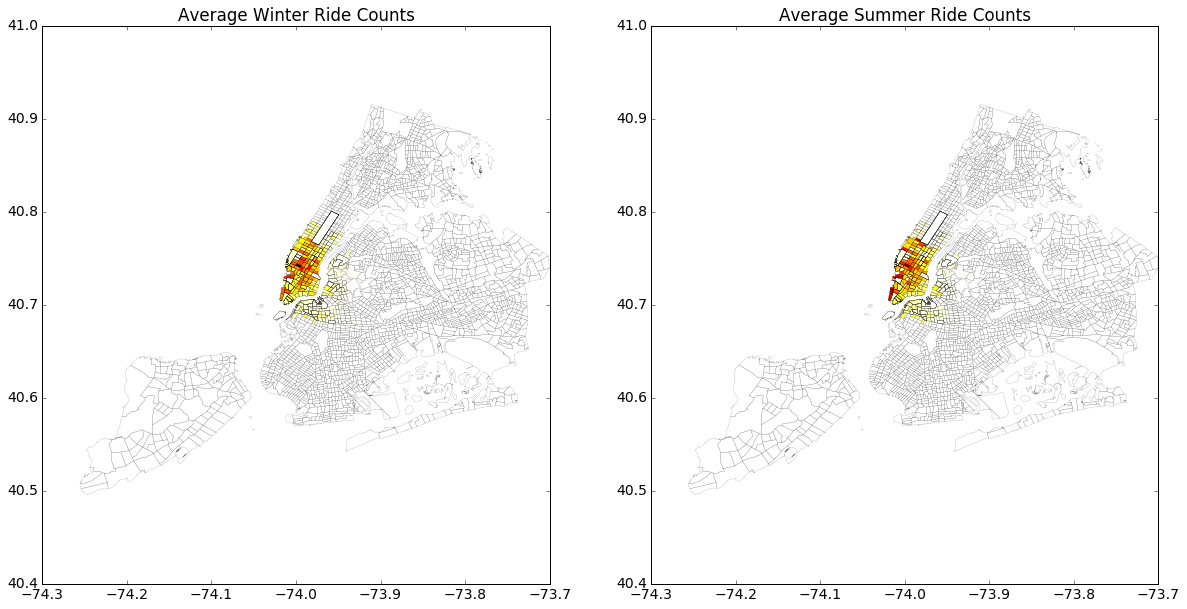

In [20]:
f, ax = plt.subplots(figsize=(20,10))
ax1 = plt.subplot(121)
ct_shape_WinterAverage.plot(column='WinterAverage',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax1)
plt.title("Average Winter Ride Counts")
ax2 = plt.subplot(122)
ct_shape_SummerAverage.plot(column='SummerAverage',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax2)
plt.title("Average Summer Ride Counts")

<b>Figure 5: </b> Map showing the average Winter and Summer ride counts by census tract, from July 2013 to July 2016. Citibike stations are only available in certain census tracts and neighborhoods at present, which is why there are so many blank census tracts.

### Removing the CTs that are out of zoom boundries

In [21]:
ct_shape_WinterAverage_Zoom=(ct_shape_WinterAverage[ct_shape_WinterAverage
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

ct_shape_SummerAverage_Zoom=(ct_shape_SummerAverage[ct_shape_SummerAverage
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

#Setting lat/long boundaries based on map above. 

In [22]:
#printing number of CTs from two separate dataframes for Winter and Summer rides.
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs (Winter):", len(temp.WinterAverage)
print "Number of zoomed CTs (Summer):", len(temp2.SummerAverage)


Total number of CTs: 2166
Number of zoomed CTs (Winter): 543
Number of zoomed CTs (Summer): 543


### Map the monthly rides 

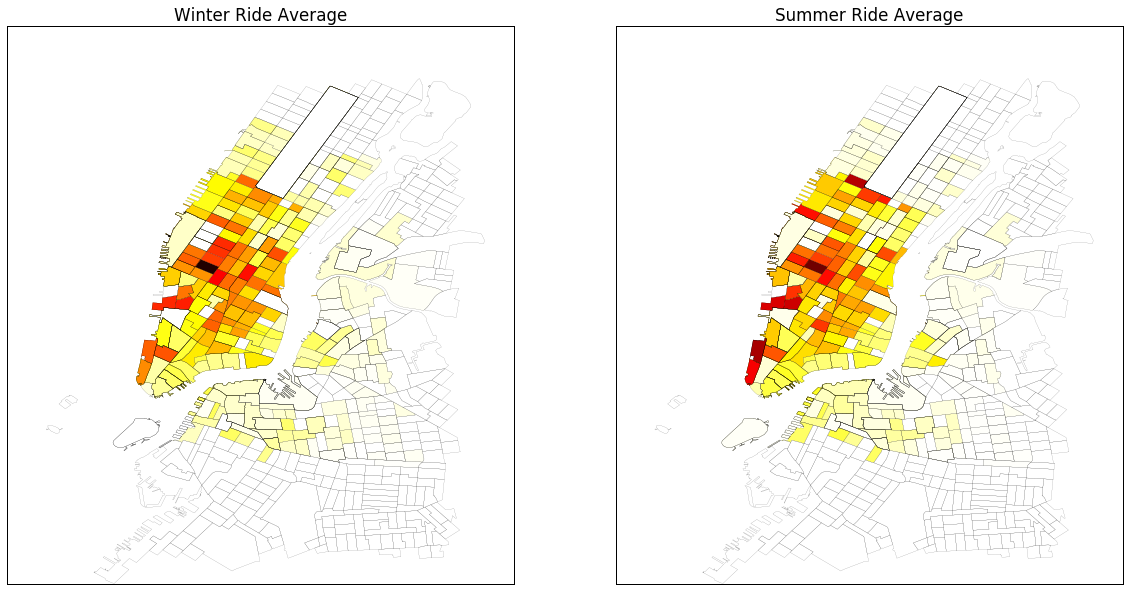

In [23]:
f, ax = plt.subplots(figsize=(20,10))

ax1 = plt.subplot(121)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ct_shape_WinterAverage_Zoom.plot(column='WinterAverage', colormap='hot_r', alpha=1, linewidth=0.1, ax=ax1)
plt.title("Winter Ride Average")

ax2 = plt.subplot(122)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ct_shape_SummerAverage_Zoom.plot(column='SummerAverage',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax2)
plt.title("Summer Ride Average")

<b>Figure 6: </b> Zoomed map showing portion of New York City that has Citibike stations and the average number of rides per census tract by season. Winter averages are on the left and summer averages are on the right.

### Export Shapefile CTs in the CitiBike Zone

In [24]:
path='Output/ct_shape_Seasons_Zoom.shp'
#Both Winter and Summer have same zoom. Can therefore export just one for the purposes
#of both.
ct_shape_WinterAverage_Zoom.to_file(path) 
                                            

## Exploratory Geospatial Analysis

In [25]:
import pysal as ps

### Spatial Weights
Contiguity: Queen Weights

In [26]:
qW_CT=ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [27]:
print qW_CT[10]

{1: 1.0, 37: 1.0, 38: 1.0, 39: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0}


In [28]:
print qW_CT.cardinalities[10]

9


#### Matrix of Weights

In [29]:
Wmatrix, ids = qW_CT.full()

In [30]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [31]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neighbors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [32]:
WinterRide=ct_shape_WinterAverage_Zoom.WinterAverage
WinterRideLag=ps.lag_spatial(qW_CT, WinterRide)

SummerRide=ct_shape_SummerAverage_Zoom.SummerAverage
SummerRideLag=ps.lag_spatial(qW_CT, SummerRide)

#### Create Quantiles for mapping

In [33]:
#Quantile... think quartile, but not constrained to 4. 
WinterRideLagQ10 = ps.Quantiles(WinterRideLag, k=10)
WinterRideLagQ10

                  Quantiles                  
 
 Lower              Upper               Count
           x[i] <=    0.000               159
   0.000 < x[i] <=    4.595                 2
   4.595 < x[i] <=   75.189                78
  75.189 < x[i] <=  180.444                80
 180.444 < x[i] <=  287.743                79
 287.743 < x[i] <=  417.840                80
 417.840 < x[i] <=  937.426                79
 937.426 < x[i] <= 1267.157                80
1267.157 < x[i] <= 1539.785                79
1539.785 < x[i] <= 2491.899                80

In [34]:
SummerRideLagQ10 = ps.Quantiles(SummerRideLag, k=10)
SummerRideLagQ10

                  Quantiles                  
 
 Lower              Upper               Count
           x[i] <=    0.000               159
   0.000 < x[i] <=    7.333                 2
   7.333 < x[i] <=  125.969                78
 125.969 < x[i] <=  256.250                80
 256.250 < x[i] <=  629.283                81
 629.283 < x[i] <=  968.988                78
 968.988 < x[i] <= 2141.150                79
2141.150 < x[i] <= 3116.268                80
3116.268 < x[i] <= 3599.888                79
3599.888 < x[i] <= 5503.042                80

In [35]:
#Zoom helps fix up 0 count above... it would otherwise be tremendously skewed. 

#### Map the monthly rides lag

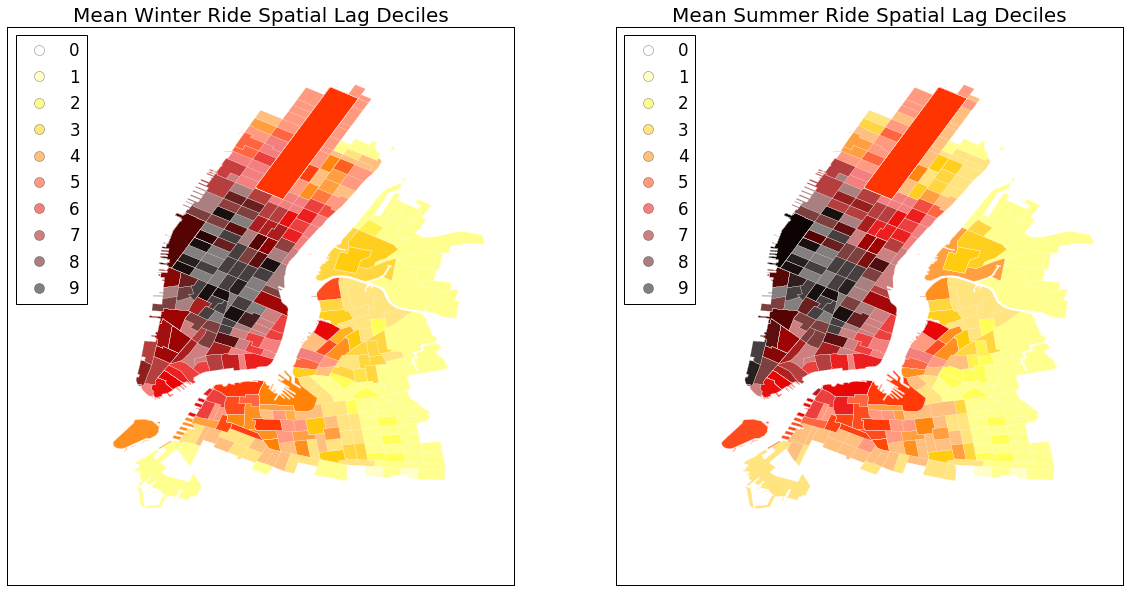

In [36]:
f, ax = plt.subplots(figsize=(20, 10))

ax1 = plt.subplot(121)
ct_shape_WinterAverage_Zoom.assign(cl=WinterRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax1, 
        edgecolor='white', legend=True)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax.set_axis_off()
plt.title("Mean Winter Ride Spatial Lag Deciles", fontsize = 20)

ax2 = plt.subplot(122)
ct_shape_SummerAverage_Zoom.assign(cl=SummerRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax2, 
        edgecolor='white', legend=True)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax.set_axis_off()
plt.title("Mean Summer Ride Spatial Lag Deciles", fontsize = 20)

<b>Figure 7: </b>Maps above visualize spatial lag deciles for Winter and Summer. Spatial lag assumes a dependency or relationship between a given census tract and the tracts directly adjacent to it as a direct result of their proximity. Deciles and coloration reflect each census tract's average for all adjacent census tracts.

## Global  Spatial Autocorrelation

In [37]:
b,a = np.polyfit(WinterRide, WinterRideLag, 1)
print "Winter auto-correlation: ", b,a 

b2,a2 = np.polyfit(SummerRide, SummerRideLag, 1)
print "Summer auto-correlation: ", b2,a2 

Winter auto-correlation:  0.661894622507 194.318136773
Summer auto-correlation:  0.643893143126 473.577589895


### Moran Scatterplot

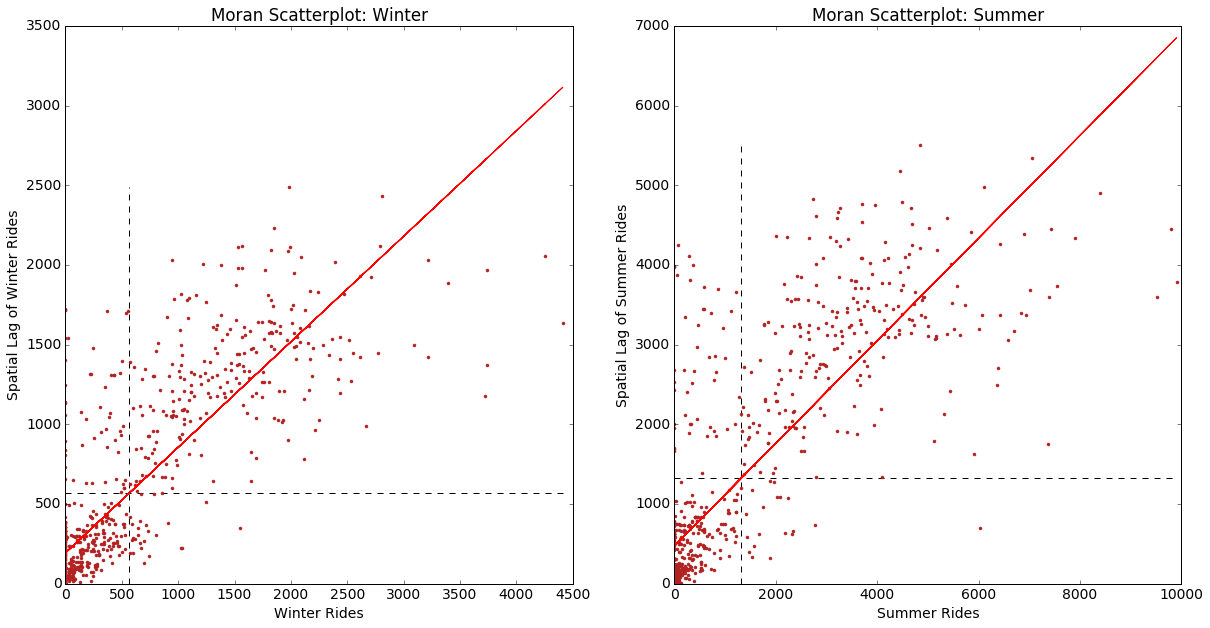

In [38]:
f, ax = plt.subplots(1, figsize=(20, 10))

ax1 = plt.subplot(121)
plt.plot(WinterRide, WinterRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(WinterRide, a + b*WinterRide, 'r')
plt.title('Moran Scatterplot: Winter')
plt.ylabel('Spatial Lag of Winter Rides')
plt.xlabel('Winter Rides')

ax2 = plt.subplot(122)
plt.plot(SummerRide, SummerRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(SummerRide, a2 + b2*SummerRide, 'r')
plt.title('Moran Scatterplot: Summer')
plt.ylabel('Spatial Lag of Summer Rides')
plt.xlabel('Summer Rides')

<b>Figure 8: </b>The above scatter plots are Moran Scatter plots for Winter and Summer. These plots assess the similarity between observed rides in each season relative to the spatial lag in that same season.

### Moran's I

In [39]:
I_WinterRide = ps.Moran(WinterRide, qW_CT)
I_SummerRide = ps.Moran(SummerRide, qW_CT)

In [40]:
print "Moran's I, Winter Rides:", I_WinterRide.I, "P-value: ", I_WinterRide.p_sim
print "Moran's I, Summer Rides:", I_SummerRide.I, "P-value: ", I_SummerRide.p_sim

#second number, after the comma, is a P-Value indicating the significance of the line above. 

Moran's I, Winter Rides: 0.662044196711 P-value:  0.001
Moran's I, Summer Rides: 0.644069499068 P-value:  0.001


Thus, the $I$ statistic for Winter is $0.662$ for this data, and has a very small $p$ value. The $I$ statistic for Summer is $0.644$ for this data, and also has a very small $p$ value.

In [41]:
print "Winter: ", I_WinterRide.sim[0:10]
print "Summer: ", I_SummerRide.sim[0:10]

Winter:  [-0.00085814  0.0082821  -0.00914216  0.02125577  0.00563727  0.01261909
  0.00887763 -0.00585272  0.01096766  0.02118781]
Summer:  [ 0.00446113 -0.00530584  0.02708498  0.02443894 -0.02696555 -0.00696389
 -0.00503858  0.00067637  0.02336167 -0.00254222]


### KDEplot of all of the simulated points
the vertical line shows the observed value

In [42]:
import seaborn as sns
plt.rcParams['figure.figsize']=(14,3)

(-0.7, 0.7)

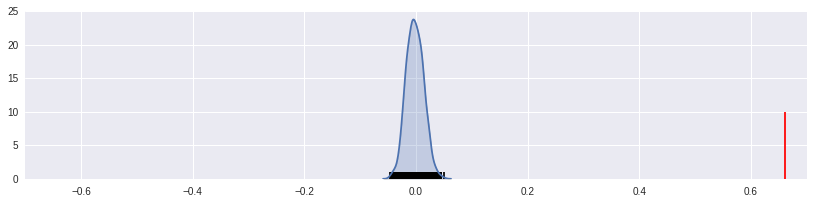

In [43]:
sns.kdeplot(I_WinterRide.sim, shade=True)
plt.vlines(I_WinterRide.sim, 0, 1)
plt.vlines(I_WinterRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

<b>Figure 9a (above): </b>Kernal Density Estimation plot of Winter rides. The red line on the right-hand side shows the observed value. 

<b> Figure 9b (below): </b>Kernal Density Estimation plot of Summer rides. The red line on the right-hand side shows the observed value. 

(-0.7, 0.7)

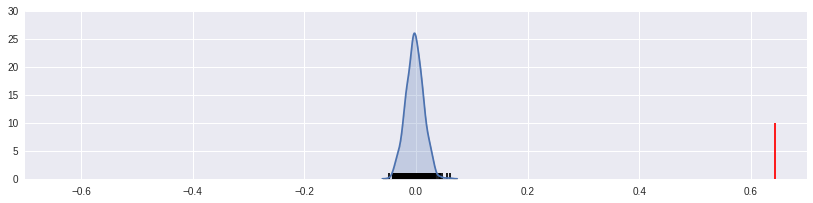

In [44]:
sns.kdeplot(I_SummerRide.sim, shade=True)
plt.vlines(I_SummerRide.sim, 0, 1)
plt.vlines(I_SummerRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

In the following figures, the vertical line shows whether our $I$ statistic was close to our expected values for Winter and Summer. 

(-0.7, 0.7)

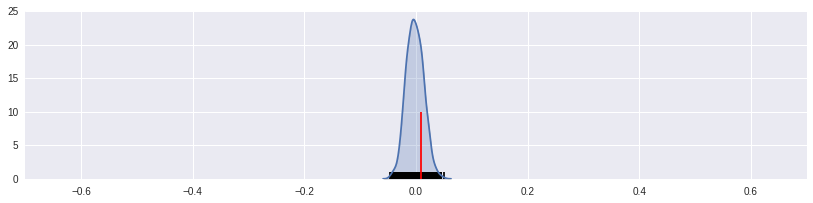

In [45]:
sns.kdeplot(I_WinterRide.sim, shade=True)
plt.vlines(I_WinterRide.sim, 0, 1)
plt.vlines(I_WinterRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

<b>Figure 10a (above):</b> red line depicts wheter $I$ statistic was cose to our expected value for <b>winter rides.</b>

(-0.7, 0.7)

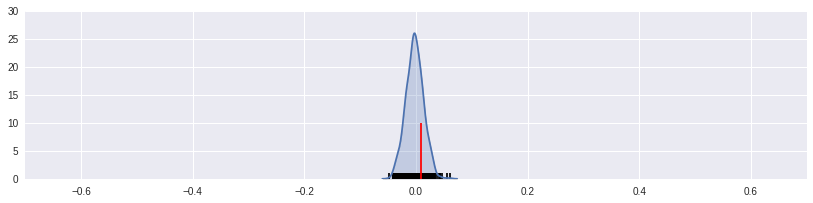

In [46]:
sns.kdeplot(I_SummerRide.sim, shade=True)
plt.vlines(I_SummerRide.sim, 0, 1)
plt.vlines(I_SummerRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

<b>Figure 10b (above):</b> red line depicts wheter $I$ statistic was cose to our expected value for <b>summer rides.</b>

## Local  Spatial Autocorrelation

In [47]:
LMo_WinterRide = ps.Moran_Local(WinterRide, qW_CT,permutations=999)
LMo_WinterRide.Is[0:5], LMo_WinterRide.p_sim[0:5]

(array([-0.        , -0.3153042 , -0.00110645, -0.00100209, -0.06082761]),
 array([ 0.001,  0.147,  0.469,  0.491,  0.437]))

In [48]:
LMo_SummerRide = ps.Moran_Local(SummerRide, qW_CT,permutations=999)
LMo_SummerRide.Is[0:5], LMo_SummerRide.p_sim[0:5]

(array([-0.        , -0.23689404,  0.01179723,  0.00235718,  0.0247348 ]),
 array([ 0.001,  0.195,  0.386,  0.347,  0.38 ]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [49]:
winter_sigs = WinterRide[LMo_WinterRide.p_sim <= .001]
winter_W_sigs = WinterRideLag[LMo_WinterRide.p_sim <= .001]
winter_insigs = WinterRide[LMo_WinterRide.p_sim > .001]
winter_W_insigs = WinterRideLag[LMo_WinterRide.p_sim > .001]

In [50]:
summer_sigs = SummerRide[LMo_SummerRide.p_sim <= .001]
summer_W_sigs = SummerRideLag[LMo_SummerRide.p_sim <= .001]
summer_insigs = SummerRide[LMo_SummerRide.p_sim > .001]
summer_W_insigs = SummerRideLag[LMo_SummerRide.p_sim > .001]

### Plot Signficant LISA

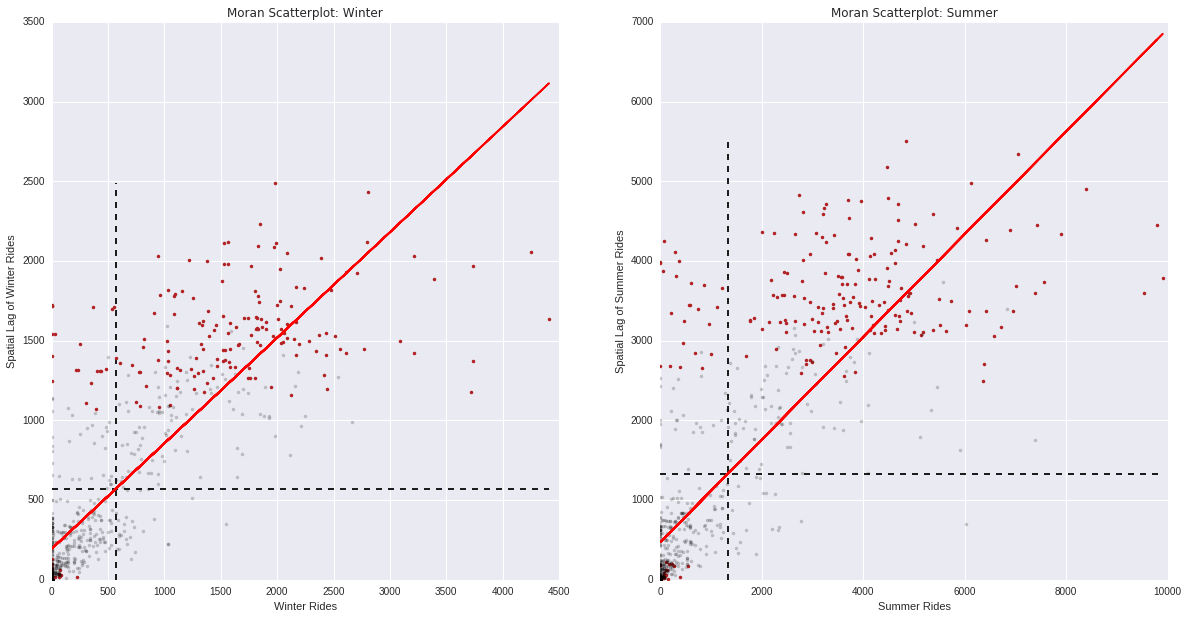

In [51]:
f, ax = plt.subplots(figsize=(20, 10))

ax1 = plt.subplot(121)
plt.plot(winter_sigs, winter_W_sigs, '.', color='firebrick')
plt.plot(winter_insigs, winter_W_insigs, '.k', alpha=.2)
#plt.text(s='$I = %.3f$' % I_WinterRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(WinterRide, a + b*WinterRide, 'r')
plt.title('Moran Scatterplot: Winter')
plt.ylabel('Spatial Lag of Winter Rides')
plt.xlabel('Winter Rides')

ax2 = plt.subplot(122)
plt.plot(summer_sigs, summer_W_sigs, '.', color='firebrick')
plt.plot(summer_insigs, summer_W_insigs, '.k', alpha=.2)
#plt.text(s='$I = %.3f$' % I_WinterRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(SummerRide, a2 + b2*SummerRide, 'r')
plt.title('Moran Scatterplot: Summer')
plt.ylabel('Spatial Lag of Summer Rides')
plt.xlabel('Summer Rides')

<b>Figure 11: </b> Moran Scatter Plots for each season showing spatial lag relative to mean rides by season. Grey points represent stations without significant spatial autocorrelation; red points represent stations with significant spatial autocorrelation.

### Hot and Cold spots 

In [ ]:
winter_sig = LMo_WinterRide.p_sim < 0.01
winter_hotspots = LMo_WinterRide.q==1 * winter_sig
winter_coldspots = LMo_WinterRide.q==3 * winter_sig
print "Number of Winter Hotspots:", winter_hotspots.sum()
print "Number of Winter Coldspots:", winter_coldspots.sum()

summer_sig = LMo_SummerRide.p_sim < 0.01
summer_hotspots = LMo_SummerRide.q==1 * summer_sig
summer_coldspots = LMo_SummerRide.q==3 * summer_sig
print "Number of Summer Hotspots:", summer_hotspots.sum()
print "Number of Summer Coldspots:", summer_coldspots.sum()

Number of Winter Hotspots: 195
Number of Winter Coldspots: 217
Number of Summer Hotspots: 189
Number of Summer Coldspots: 247


In [ ]:
from matplotlib import colors

hcmap = colors.ListedColormap(['grey','red','blue'])
winter_hotcold = winter_hotspots*1 + winter_coldspots*2
summer_hotcold = summer_hotspots*1 + summer_coldspots*2

f, ax = plt.subplots(figsize=(20, 10))
ax1 = plt.subplot(121)
ct_shape_WinterAverage_Zoom.assign(cl=winter_hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax1, 
        edgecolor='white')
ax1.set_axis_off()
plt.title("Winter Mean Spatial Lag Deciles", fontsize = 20)
ax1.plot(station_id['lon'], station_id['lat'], '.', color = 'k')

ax2 = plt.subplot(122)
ct_shape_SummerAverage_Zoom.assign(cl = summer_hotcold).plot(column = 'cl', categorical = True, 
        k = 10, cmap = hcmap, linewidth = 0.1, ax = ax2, 
        edgecolor = 'white', legend = False)
ax2.set_axis_off()
plt.title("Summer Mean Spatial Lag Deciles", fontsize = 20)
ax2.plot(station_id['lon'], station_id['lat'], '.', color = 'k')

<b>Figure 12: </b> Maps above show spatial autocorrelation in terms of a heat map. Black dots represent the locations of stations across the city. Red clusters are "hot spots" and show high spatial correlation between census tracts, with high mean ridership at the stations in those areas. Blue clusters are cold spots, with mean ridership in those clusters low. Many of the blue census tracts in fact lack stations at all. Grey districts show no spatial autocorrelation and relative neutrality in terms of popularity and mean riderhsip.